In [7]:
import pandas as pd
import numpy as np
import os
import json
import re
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import random
import time

import torch.nn as nn
import torch
from torch.utils.tensorboard import SummaryWriter

from typing import List, Union

## Dataset Inspection

In [17]:
data_dir = './'
work_dir = './work'
exclude_z = True

train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
metadata = pd.read_csv(os.path.join(data_dir, 'supplemental_metadata.csv'))
with open(os.path.join(data_dir, 'character_to_prediction_index.json')) as f:
    c2e = json.load(f)

# this is our encoding
e2c = {v:k for k,v in c2e.items()}

def encode(c):
    return c2e[c]
def decode(e):
    return e2c[e]

def filter_cols(columns: list, pattern) -> list:
            return list(filter(lambda x: not re.search(pattern, x), columns))


hand_labels = ['x_left_hand_0', 'x_left_hand_1', 'x_left_hand_2', 'x_left_hand_3', 'x_left_hand_4', 'x_left_hand_5', 'x_left_hand_6', 'x_left_hand_7', 'x_left_hand_8', 'x_left_hand_9', 'x_left_hand_10', 'x_left_hand_11', 'x_left_hand_12', 'x_left_hand_13', 'x_left_hand_14', 'x_left_hand_15', 'x_left_hand_16', 'x_left_hand_17', 'x_left_hand_18', 'x_left_hand_19', 'x_left_hand_20', 'x_right_hand_0', 'x_right_hand_1', 'x_right_hand_2', 'x_right_hand_3', 'x_right_hand_4', 'x_right_hand_5', 'x_right_hand_6', 'x_right_hand_7', 'x_right_hand_8', 'x_right_hand_9', 'x_right_hand_10', 'x_right_hand_11', 'x_right_hand_12', 'x_right_hand_13', 'x_right_hand_14', 'x_right_hand_15', 'x_right_hand_16', 'x_right_hand_17', 'x_right_hand_18', 'x_right_hand_19', 'x_right_hand_20', 'y_left_hand_0', 'y_left_hand_1', 'y_left_hand_2', 'y_left_hand_3', 'y_left_hand_4', 'y_left_hand_5', 'y_left_hand_6', 'y_left_hand_7', 'y_left_hand_8', 'y_left_hand_9', 'y_left_hand_10', 'y_left_hand_11', 'y_left_hand_12', 'y_left_hand_13', 'y_left_hand_14', 'y_left_hand_15', 'y_left_hand_16', 'y_left_hand_17', 'y_left_hand_18', 'y_left_hand_19', 'y_left_hand_20', 'y_right_hand_0', 'y_right_hand_1', 'y_right_hand_2', 'y_right_hand_3', 'y_right_hand_4', 'y_right_hand_5', 'y_right_hand_6', 'y_right_hand_7', 'y_right_hand_8', 'y_right_hand_9', 'y_right_hand_10', 'y_right_hand_11', 'y_right_hand_12', 'y_right_hand_13', 'y_right_hand_14', 'y_right_hand_15', 'y_right_hand_16', 'y_right_hand_17', 'y_right_hand_18', 'y_right_hand_19', 'y_right_hand_20', 'z_left_hand_0', 'z_left_hand_1', 'z_left_hand_2', 'z_left_hand_3', 'z_left_hand_4', 'z_left_hand_5', 'z_left_hand_6', 'z_left_hand_7', 'z_left_hand_8', 'z_left_hand_9', 'z_left_hand_10', 'z_left_hand_11', 'z_left_hand_12', 'z_left_hand_13', 'z_left_hand_14', 'z_left_hand_15', 'z_left_hand_16', 'z_left_hand_17', 'z_left_hand_18', 'z_left_hand_19', 'z_left_hand_20', 'z_right_hand_0', 'z_right_hand_1', 'z_right_hand_2', 'z_right_hand_3', 'z_right_hand_4', 'z_right_hand_5', 'z_right_hand_6', 'z_right_hand_7', 'z_right_hand_8', 'z_right_hand_9', 'z_right_hand_10', 'z_right_hand_11', 'z_right_hand_12', 'z_right_hand_13', 'z_right_hand_14', 'z_right_hand_15', 'z_right_hand_16', 'z_right_hand_17', 'z_right_hand_18', 'z_right_hand_19', 'z_right_hand_20']

if exclude_z:
    hand_labels = filter_cols(hand_labels, 'z')

def load_sequence(file, seq_id, filter=hand_labels):
    return pd.read_parquet(file, columns=filter).loc[seq_id]

def parquet_match(x):
    match = re.match(r'(\d+)\.parquet', x)
    if match:
        return int(match.group(1))
file_ids = set(map(parquet_match, os.listdir(os.path.join(data_dir, 'train_landmarks'))))

train = train[train.file_id.isin(file_ids)]
# shuffle dataset within file groups
train = train.groupby('file_id').sample(frac=1).reset_index(drop=True)

Training target: 8339 indigo loch lane
null seqeunce length: 0


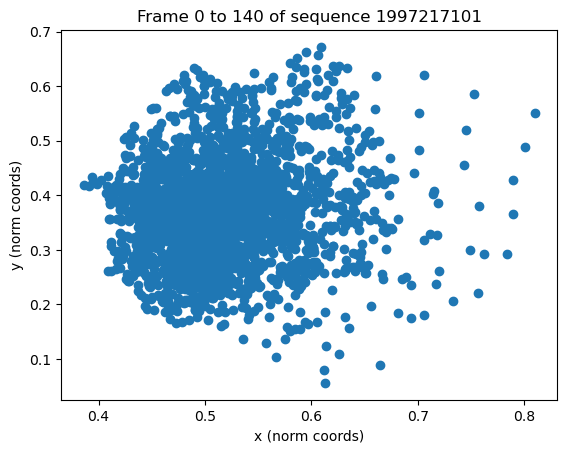

In [54]:
# doing some data exploration
random_row = train.sample().iloc[0]
seq_id = random_row.sequence_id
test_seq = load_sequence(str(random_row.path), seq_id)
print(f'Training target: {random_row.phrase}')
print('null seqeunce length:', test_seq.isna().all(axis=1).sum())

x_labels = filter_cols(test_seq.columns, '^x')
y_labels = filter_cols(test_seq.columns, '^y')
start_frame = 0
end_frame = len(test_seq)
plt.scatter(test_seq[x_labels].iloc[start_frame:end_frame], test_seq[y_labels].iloc[start_frame:end_frame])
plt.xlabel('x (norm coords)')
plt.ylabel('y (norm coords)')
plt.title(f'Frame {start_frame} to {end_frame} of sequence {seq_id}')
plt.show()

In [52]:
full_frame_noz['y_right_hand_7']

sequence_id
2000057143    0.409658
2000057143    0.402921
2000057143    0.443525
2000057143    0.382283
2000057143    0.412219
                ...   
2000057143    0.195152
2000057143    0.254625
2000057143    0.200282
2000057143    0.191530
2000057143    0.175172
Name: x_right_hand_7, Length: 66, dtype: float32

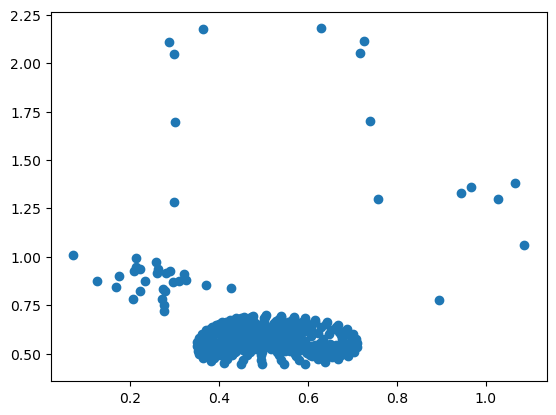

In [53]:
full_frame = load_sequence(str(random_row.path), seq_id, None).drop('frame', axis=1)
full_frame = full_frame[sorted(full_frame.columns, key=lambda x: x[2:])] # group the columns by their feature in three coordinates (x,y,z)
full_frame_noz = full_frame[filter(lambda x: 'z' not in x, full_frame.columns)]
i = 0
x_coords = full_frame_noz[full_frame_noz.columns[::2]].iloc[i]
y_coords = full_frame_noz[full_frame_noz.columns[1::2]].iloc[i]
plt.scatter(x_coords, y_coords)

In [75]:
sum(['face' in x for x in set(map(lambda x: x[2:], full_frame.columns))])

468

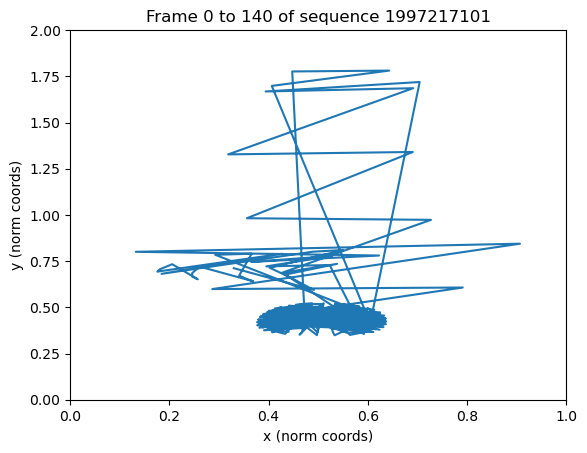

In [71]:
fig, ax = plt.subplots()
scat, = ax.plot([])
ax.set_xlim(0, 1)
ax.set_ylim(0,2)
full_frame = load_sequence(str(random_row.path), seq_id, None).drop('frame', axis=1)
full_frame = full_frame[sorted(full_frame.columns, key=lambda x: x[2:])] # group the columns by their feature in three coordinates (x,y,z)

def plot_animation(frame):
    x = full_frame[full_frame.columns[::3]].iloc[frame]
    y = full_frame[full_frame.columns[1::3]].iloc[frame]
    scat.set_data((x, y))


anim = FuncAnimation(fig, plot_animation, frames=range(len(test_seq)))
plt.title(f'Frame {start_frame} to {end_frame} of sequence {seq_id}')
plt.xlabel('x (norm coords)')
plt.ylabel('y (norm coords)')
# plt.show()
anim.save('example.gif', fps=15)

In [34]:
full_frame_noz.columns[:,2]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [24]:
NUM_NODES

118

To visualize an animation of this sequence, use the following code snippet:

```python
fig, ax = plt.subplots()
scat, = ax.plot([])
ax.set_xlim(0, 1)
ax.set_ylim(0,1)

def plot_animation(frame):
    x = test_seq[x_labels].iloc[frame]
    y = test_seq[y_labels].iloc[frame]
    scat.set_data((x, y))


anim = FuncAnimation(fig, plot_animation, frames=range(len(test_seq)))
plt.title(f'Frame {start_frame} to {end_frame} of sequence {seq_id}')
plt.xlabel('x (norm coords)')
plt.ylabel('y (norm coords)')
# plt.show()
anim.save('example.gif', fps=15)
```

which produces something like the following for the sequence label "mauricio7jorge"

![hand animation](fig/example_feature_sequence.gif)

#### Side note
Here we see that left and right hands are often mutually exclusive, but perhaps not always. We may consider creating an encoding for the hand in use to reduce the number of inputs to the nn model by a factor of 2.

After further consideration, it seems like this will be an irrelevant consideration. Especially when using models that use attention mechanisms and are specifically designed to ignore features that do not relate to the output. I'm assuming that we will eventually use transformers here.

In [18]:
# this just asserts that the left hand is also present in training data. We will want to train on both hands and thus should come up with a means of determining which hand is being used
table = pd.read_parquet('train_landmarks/1019715464.parquet', columns=hand_labels)
table[pd.isna(table.x_left_hand_0)].index.unique().size

992

## Dataset preprocessing
We can reduce the dimensionality of this dataset by applying incremental PCA to all or a subset of the sequences

TODO

## Data loader Design

We design a data loader that can batch and random sort efficiently across the large parquet file dataset. This requires a few steps of preprocessing and sorting but in the end removes the feature loading bottleneck that I was dealing with when initially training this model.

The steps are roughly as follows:
1. If we haven't already found the validated manifest file, create a new one by checking the existence of each file in the manifest and including in the validated only if it exists
2. some sort of shuffling logic that shuffles between files so that we don't have sequential access to multiple parquets before each parquet has been completely finished. This way, we don't get any filesystem slowdown
3. 

In [2]:
# map data class, requires a sampler to provide indices. We resort to the iterated dataset to
class ASLData(torch.utils.data.Dataset):
    """
    Fast, randomized ASL dataset that reads parquet files in the 'train_landmarks' folder of root_data_dir
    """
    def __init__(self, root_data_dir, working_dir, PAD=-1, input_length=150, output_length=None, exclude_z=True):
        """
        Parameters
        ==========
        root_data_dir: the data directory where 'train_landmarks' is located
        working_dir: directory where manifest is stored
        PAD: the token we use to pad the ends of sequences in batches
        input_length: truncation length of the inputs
        output_length: truncation length of the output sequences
        exclude_z: exclude the z-coordinate in the feature set
        """
        super().__init__()
        
        # these are for parquet loading
        self.current_file_id = None
        self.current_parquet = None

        # hardcode these for faster parquet retrieval. Otherwise we have to load the file to parse the header
        self.hand_labels = ['x_left_hand_0', 'x_left_hand_1', 'x_left_hand_2', 'x_left_hand_3', 'x_left_hand_4', 'x_left_hand_5', 'x_left_hand_6', 'x_left_hand_7', 'x_left_hand_8', 'x_left_hand_9', 'x_left_hand_10', 'x_left_hand_11', 'x_left_hand_12', 'x_left_hand_13', 'x_left_hand_14', 'x_left_hand_15', 'x_left_hand_16', 'x_left_hand_17', 'x_left_hand_18', 'x_left_hand_19', 'x_left_hand_20', 'x_right_hand_0', 'x_right_hand_1', 'x_right_hand_2', 'x_right_hand_3', 'x_right_hand_4', 'x_right_hand_5', 'x_right_hand_6', 'x_right_hand_7', 'x_right_hand_8', 'x_right_hand_9', 'x_right_hand_10', 'x_right_hand_11', 'x_right_hand_12', 'x_right_hand_13', 'x_right_hand_14', 'x_right_hand_15', 'x_right_hand_16', 'x_right_hand_17', 'x_right_hand_18', 'x_right_hand_19', 'x_right_hand_20', 'y_left_hand_0', 'y_left_hand_1', 'y_left_hand_2', 'y_left_hand_3', 'y_left_hand_4', 'y_left_hand_5', 'y_left_hand_6', 'y_left_hand_7', 'y_left_hand_8', 'y_left_hand_9', 'y_left_hand_10', 'y_left_hand_11', 'y_left_hand_12', 'y_left_hand_13', 'y_left_hand_14', 'y_left_hand_15', 'y_left_hand_16', 'y_left_hand_17', 'y_left_hand_18', 'y_left_hand_19', 'y_left_hand_20', 'y_right_hand_0', 'y_right_hand_1', 'y_right_hand_2', 'y_right_hand_3', 'y_right_hand_4', 'y_right_hand_5', 'y_right_hand_6', 'y_right_hand_7', 'y_right_hand_8', 'y_right_hand_9', 'y_right_hand_10', 'y_right_hand_11', 'y_right_hand_12', 'y_right_hand_13', 'y_right_hand_14', 'y_right_hand_15', 'y_right_hand_16', 'y_right_hand_17', 'y_right_hand_18', 'y_right_hand_19', 'y_right_hand_20', 'z_left_hand_0', 'z_left_hand_1', 'z_left_hand_2', 'z_left_hand_3', 'z_left_hand_4', 'z_left_hand_5', 'z_left_hand_6', 'z_left_hand_7', 'z_left_hand_8', 'z_left_hand_9', 'z_left_hand_10', 'z_left_hand_11', 'z_left_hand_12', 'z_left_hand_13', 'z_left_hand_14', 'z_left_hand_15', 'z_left_hand_16', 'z_left_hand_17', 'z_left_hand_18', 'z_left_hand_19', 'z_left_hand_20', 'z_right_hand_0', 'z_right_hand_1', 'z_right_hand_2', 'z_right_hand_3', 'z_right_hand_4', 'z_right_hand_5', 'z_right_hand_6', 'z_right_hand_7', 'z_right_hand_8', 'z_right_hand_9', 'z_right_hand_10', 'z_right_hand_11', 'z_right_hand_12', 'z_right_hand_13', 'z_right_hand_14', 'z_right_hand_15', 'z_right_hand_16', 'z_right_hand_17', 'z_right_hand_18', 'z_right_hand_19', 'z_right_hand_20']
        if exclude_z:
            self.hand_labels = list(filter(lambda x: re.search('[xy]_', x), self.hand_labels))
        
        # create train manifest
        self.root_data_dir = root_data_dir
        self.working_dir = working_dir
        self.manifest = self._create_manifest(self.root_data_dir)
        
        if output_length:
            self.max_output_len = output_length
        else:
            self.max_output_len = max(list(map(len, self.manifest.phrase)))
        self.input_length = input_length


        # our character encoding function
        with open(os.path.join(root_data_dir, 'character_to_prediction_index.json')) as f:
            self.c2e = json.load(f)
        self.e2c = {v:k for k,v in self.c2e.items()}

        # the pad token
        self.pad = PAD
            
    def _create_manifest(self, root_data_dir: str) -> pd.DataFrame:
        if os.path.exists(os.path.join(self.working_dir, 'manifest.csv')):
            manifest = pd.read_csv(os.path.join(self.working_dir, 'manifest.csv'))
        
        else:
            train = pd.read_csv(os.path.join(root_data_dir, 'train.csv'))

            # create the list of files that we can parse
            def parquet_match(x):
                match = re.match(r'(\d+)\.parquet', x)
                if match:
                    return int(match.group(1))
            file_ids = set(map(parquet_match, os.listdir(os.path.join(root_data_dir, 'train_landmarks'))))

            train = train[train.file_id.isin(file_ids)].sort_values('file_id').reset_index(drop=True)
            drops = []
            for idx in train.index:
                row = train.loc[idx]
                parquet = self._load_parquet(row)
                seq = parquet.loc[row.sequence_id]
                if type(seq) != pd.DataFrame:
                    drops += [idx]
            manifest = train.drop(drops)
            manifest.to_csv(os.path.join(self.working_dir, 'manifest.csv'))
            
        return manifest
                
    def _load_parquet(self, row):
        """Function that caches the current parquet so we don't have to do redundant reads of parquet files"""
        if row.file_id != self.current_file_id:
#             print(f'switching to file {row.file_id}')
            parquet_path = os.path.join(self.root_data_dir, row.path)
            self.current_parquet = pd.read_parquet(parquet_path, columns=self.hand_labels)
            self.current_file_id  = row.file_id
        
        return self.current_parquet
        
    def _encode(self, c):
        return self.c2e[c]

    def _decode(self, e):
        return self.e2c[e]
            
    def __getitem__(self, idx):
        row = self.manifest.loc[idx]
        parquet = self._load_parquet(row)
            
        # we need to pad sequences and targets
        seq = parquet.loc[row.sequence_id].fillna(self.pad)
        seq = torch.tensor(seq.to_numpy())
        
        label = torch.torch.tensor(list(map(self._encode, row.phrase)))
        
        seq_len = len(seq)
        label_len = len(label)
    
        # pad sequences and targets
        label = nn.functional.pad(label, (0, self.max_output_len - label_len))
        if seq_len > self.input_length:
            print(f'Warning: input length of {seq_len} processed. Truncating but you may want to extend the input dimension to acommodate this example')
            seq = seq[:self.input_length]
        else:
            seq = torch.concat([seq, torch.zeros(self.input_length - seq_len, seq.size()[1])])
        return seq, label, seq_len, label_len
    
    def __len__(self):
        return len(self.manifest) - 1


class ASLDataSampler(torch.utils.data.Sampler):
    def __init__(self, indices: pd.Index):
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __iter__(self):
        return iter(self.indices)
            
def train_val_test_samplers(dataset: ASLData, train: float, val: float, test: float) -> (pd.Index, pd.Index, pd.Index):
    assert train + val + test == 1 and train >= 0 and test >= 0 and val >= 0 # I guess this is overparameterized. we can do without one of these
    manifest_indices = dataset.manifest.groupby('file_id').sample(frac=1).index
    n1, n2 = int(len(manifest_indices)*train), int(len(manifest_indices)*(train + val))
    return (ASLDataSampler(manifest_indices[:n1]), ASLDataSampler(manifest_indices[n1:n2]), ASLDataSampler(manifest_indices[n2:]))

In [3]:
### The regular ASLData should be used instead of the iterable set. This was only here to compare my own batching techniques with pytorch's
class ASLIterData(torch.utils.data.IterableDataset):
    """
    Fast, randomized, iterable ASL dataset that reads parquet files in the 'train_landmarks' folder of root_data_dir
    """
    def __init__(self, root_data_dir, input_length=150, output_length=None, exclude_z=True, batch_size=20, set_type='train'):
        super().__init__()
        # create train manifest
        self.root_data_dir = root_data_dir
        self.set_type = set_type
        self.train = self._create_manifest(self.root_data_dir)
        
        
        # member definitions for the iterator
        def filter_cols(columns: list, pattern) -> list:
            return list(filter(lambda x: re.search(pattern, x), columns))
        # hardcode these for faster parquet retrieval. Otherwise we have to load the file to parse the header
        self.hand_labels = ['x_left_hand_0', 'x_left_hand_1', 'x_left_hand_2', 'x_left_hand_3', 'x_left_hand_4', 'x_left_hand_5', 'x_left_hand_6', 'x_left_hand_7', 'x_left_hand_8', 'x_left_hand_9', 'x_left_hand_10', 'x_left_hand_11', 'x_left_hand_12', 'x_left_hand_13', 'x_left_hand_14', 'x_left_hand_15', 'x_left_hand_16', 'x_left_hand_17', 'x_left_hand_18', 'x_left_hand_19', 'x_left_hand_20', 'x_right_hand_0', 'x_right_hand_1', 'x_right_hand_2', 'x_right_hand_3', 'x_right_hand_4', 'x_right_hand_5', 'x_right_hand_6', 'x_right_hand_7', 'x_right_hand_8', 'x_right_hand_9', 'x_right_hand_10', 'x_right_hand_11', 'x_right_hand_12', 'x_right_hand_13', 'x_right_hand_14', 'x_right_hand_15', 'x_right_hand_16', 'x_right_hand_17', 'x_right_hand_18', 'x_right_hand_19', 'x_right_hand_20', 'y_left_hand_0', 'y_left_hand_1', 'y_left_hand_2', 'y_left_hand_3', 'y_left_hand_4', 'y_left_hand_5', 'y_left_hand_6', 'y_left_hand_7', 'y_left_hand_8', 'y_left_hand_9', 'y_left_hand_10', 'y_left_hand_11', 'y_left_hand_12', 'y_left_hand_13', 'y_left_hand_14', 'y_left_hand_15', 'y_left_hand_16', 'y_left_hand_17', 'y_left_hand_18', 'y_left_hand_19', 'y_left_hand_20', 'y_right_hand_0', 'y_right_hand_1', 'y_right_hand_2', 'y_right_hand_3', 'y_right_hand_4', 'y_right_hand_5', 'y_right_hand_6', 'y_right_hand_7', 'y_right_hand_8', 'y_right_hand_9', 'y_right_hand_10', 'y_right_hand_11', 'y_right_hand_12', 'y_right_hand_13', 'y_right_hand_14', 'y_right_hand_15', 'y_right_hand_16', 'y_right_hand_17', 'y_right_hand_18', 'y_right_hand_19', 'y_right_hand_20', 'z_left_hand_0', 'z_left_hand_1', 'z_left_hand_2', 'z_left_hand_3', 'z_left_hand_4', 'z_left_hand_5', 'z_left_hand_6', 'z_left_hand_7', 'z_left_hand_8', 'z_left_hand_9', 'z_left_hand_10', 'z_left_hand_11', 'z_left_hand_12', 'z_left_hand_13', 'z_left_hand_14', 'z_left_hand_15', 'z_left_hand_16', 'z_left_hand_17', 'z_left_hand_18', 'z_left_hand_19', 'z_left_hand_20', 'z_right_hand_0', 'z_right_hand_1', 'z_right_hand_2', 'z_right_hand_3', 'z_right_hand_4', 'z_right_hand_5', 'z_right_hand_6', 'z_right_hand_7', 'z_right_hand_8', 'z_right_hand_9', 'z_right_hand_10', 'z_right_hand_11', 'z_right_hand_12', 'z_right_hand_13', 'z_right_hand_14', 'z_right_hand_15', 'z_right_hand_16', 'z_right_hand_17', 'z_right_hand_18', 'z_right_hand_19', 'z_right_hand_20']
        if exclude_z:
            self.hand_labels = filter_cols(self.hand_labels, '[xy]_')
        
        if output_length:
            self.max_output_len = output_length
        else:
            self.max_output_len = max(list(map(len, self.train.phrase)))
        self.input_length = input_length
        self.batch_size = batch_size


        # our character encoding function
        with open(os.path.join(root_data_dir, 'character_to_prediction_index.json')) as f:
            self.c2e = json.load(f)
        self.e2c = {v:k for k,v in self.c2e.items()}
        self.vocab_size = len(self.e2c)
        
            
    def _create_manifest(self, root_data_dir: str) -> pd.DataFrame:
        train = pd.read_csv(os.path.join(root_data_dir, 'train.csv'))

        # create the list of files that we can parse
        def parquet_match(x):
            match = re.match(r'(\d+)\.parquet', x)
            if match:
                return int(match.group(1))
        file_ids = set(map(parquet_match, os.listdir(os.path.join(root_data_dir, f'{self.set_type}_landmarks'))))

        return train[train.file_id.isin(file_ids)]

    def _encode(self, c):
        return self.c2e[c]
    def _decode(self, e):
        return self.e2c[e]

    def __iter__(self):
        # shuffle the dataset
        self.train = self.train.groupby('file_id').sample(frac=1).reset_index(drop=True)

        current_parquet = None
        current_file_id = None
        n = len(self.train)
        for i in range(n // self.batch_size):
            batch_len, j = 0, 0
            index = i*self.batch_size
            seq = torch.zeros((self.batch_size, self.input_length, len(self.hand_labels)))
            label = torch.zeros((self.batch_size, self.max_output_len), dtype=int)
            seq_len = torch.zeros(self.batch_size, dtype=int)
            label_len = torch.zeros(self.batch_size, dtype=int)
            while batch_len < self.batch_size and index + j < n:
                row = self.train.loc[index + j]
                if row.file_id == current_file_id:
                    parquet = current_parquet
                else:
                    if self.set_type == 'train':
                        parquet_path = os.path.join(self.root_data_dir, row.path)
                    else:
                        parquet_path = os.path.join(self.root_data_dir, re.sub('train', 'test', row.path))
                    parquet = pd.read_parquet(parquet_path, columns=self.hand_labels)
                    current_parquet = parquet
                    current_file_id = row.file_id
                if not row.sequence_id in parquet.index:
                    # skip this sample
                    j += 1
                    continue
                else:
                    # include this sample
                    seq_sample = torch.tensor(parquet.loc[row.sequence_id].fillna(0).to_numpy())
                    label_sample = torch.tensor(list(map(self._encode, row.phrase)))
                    
                    seq[batch_len,:len(seq_sample)] = seq_sample
                    label[batch_len,:len(label_sample)] = label_sample
                    seq_len[batch_len] = len(seq_sample)
                    label_len[batch_len] = len(label_sample)
                    j += 1
                    batch_len += 1

            if batch_len < self.batch_size:
                # truncate the examples, should only have to do this at the end of the dataset
                seq = seq_sample[:batch_len]
                label = label_sample[:batch_len:]
                seq_len = seq_len[:batch_len]
                label_len = seq_len[:batch_len]

            yield seq, label, seq_len, label_len
    def __len__(self):
        """*Approximate* length of this dataloader. Warning: this is not an exact count, as there is logic that omits missing samples in the iter function itself. Do not use in any application where an exact length is required"""
        return len(self.train)

In [4]:
class ASLTestData(torch.utils.data.Dataset):
    """
    Test data set for sanity check on CTC training
    """
    def __init__(self, len, input_length=150, output_length=30, exclude_z=True):
        super().__init__()

        self.len = len
        self.seq = torch.zeros((input_length, 84))
        stride = input_length // 4
        self.seq[stride:2*stride, :] = 1
        self.seq[3*stride:, :] = 1
        self.label = torch.tensor([1, 2, 1, 2])
            
    def __getitem__(self, idx):
        seq, label = self.seq, self.labelq
        seq_len, label_len = len(seq), len(label)
        return seq, label, seq_len, label_len
    
    def __len__(self):
        return self.len

## Baseline Model Design and Training
We explore the feasibility of a number of models, some of which address a subset of the original problem task. In particular, we assign our baseline model the task of predicting the first character of the label so that we can get an estimate of how well the model can extract character-specific data from the feature sequences.

We then move onto more 

In [5]:
class ASLFirstCharacterClassifier(nn.Module):
    """
    Our baseline model which attempts to classify the first character in the sequence. The following model:
    masking
    dense
    batchnorm
    3x convolution layers
    dense
    late dropout
    dense
    """
    def __init__(self, d_model: int, input_size: int=1024, vocab_size: int=59, dropout=0.2):
        super().__init__()
        self.d_model = d_model
        
        self.layers = nn.Sequential(
            nn.Linear(84, 192, bias=False,)
            nn.BatchNorm1d(192, momentum=0.95)
            nn.Conv1d(192, 17, dropout=0.2)
            nn.ReLU()
            nn.Conv1d(192, 17, dropout=0.2)
            nn.ReLU()
            nn.TransformerEncoderLayer(192, 3)
            nn.Conv1d(192, 17, dropout=0.2)
            
        )
        
        self.conv1  = nn.Conv1d(self.d_model, self.d_model//2, 7, 3) # this filter should correspond roughly with how long each character is in time
        self.maxp1 = nn.MaxPool1d(kernel_size=10, stride=5)
        self.conv2  = nn.Conv1d(self.d_model//2, self.d_model//4, 5, 2)
        self.maxp2 = nn.MaxPool1d(kernel_size=5, stride=5)
        self.conv3 = nn.Conv1d(self.d_model//4, self.d_model//8, 2, 1)
        self.maxp3 = nn.MaxPool1d(kernel_size=5, stride=1)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p=dropout)
        self.l1 = nn.Linear(10,1)
        self.sig = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, d_model]``
        """
        x = x.transpose(1,2)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxp1(x)
#         x = self.drop(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxp2(x)
#         x = self.drop(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxp3(x).squeeze(-1)
        x = self.drop(x)
        x = self.l1(x).squeeze(1)
        x = self.sig(x)
        return x

SyntaxError: invalid syntax (441645481.py, line 18)

In [11]:
x = torch.masked.MaskedTensor(torch.randn((5, 5)), ~torch.eye(5, dtype=bool)) 
nn.functional.conv1d(x, torch.ones((2,2)))

/opt/homebrew/Caskroom/miniconda/base/envs/dl/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "
/opt/homebrew/Caskroom/miniconda/base/envs/dl/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:299: UserWarning: convolution is not implemented in __torch_dispatch__ for MaskedTensor.
If you would like this operator to be supported, please file an issue for a feature request at https://github.com/pytorch/maskedtensor/issues with a minimal reproducible code snippet.
In the case that the semantics for the operator are not trivial, it would be appreciated to also include a proposal for the semantics.
  warnings.warn(msg)


TypeError: no implementation found for 'torch._ops.aten.convolution.default' on types that implement __torch_dispatch__: [<class 'torch.masked.maskedtensor.core.MaskedTensor'>]

In [242]:
### Model Training ###
input_length = 1024
batch_size = 32
n_epochs = 10
ds = ASLData('/kaggle/input/asl-fingerspelling/', '/kaggle/working', input_length=input_length)
train_samp, val_samp, test_samp = train_val_test_samplers(ds, 0.8, 0.1, 0.1)
train_loader = torch.utils.data.DataLoader(ds, batch_size=batch_size, sampler=train_samp)
val_loader = torch.utils.data.DataLoader(ds, batch_size=batch_size, sampler=val_samp)

## model training
ce_loss = nn.BCELoss()
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model = ASLFirstCharacterClassifier(d_model=84, input_size=input_length).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.001)

## We'll use tensorboard for visualizations
# writer = SummaryWriter()

model.train()

total_loss = 0
log_interval = 150
start_time = time.time()
num_batches = len(train_loader)

loss_idx_value = 0
for epoch in range(n_epochs):
    train_loader = torch.utils.data.DataLoader(ds, batch_size=batch_size, sampler=train_samp, num_workers=2)
    
    model.train()
    for batch, (seq, phrase, seq_len, phrase_len) in enumerate(train_loader):
        seq = seq.to(device)
        phrase = phrase.to(device)
        
        pred = model(seq)
        contains_a = (torch.sum(phrase == ds._encode('a'), dim=1) > 0).float()
        loss = ce_loss(pred, contains_a)
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        total_loss += loss.item()
        # writer.add_scalar('Loss', loss.item(), loss_idx_value)
        loss_idx_value += 1
        if batch % log_interval == 0 and batch > 0:
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            print(f'|train epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                 f'ms/batch {ms_per_batch:5.2f} | '
                 f'loss {cur_loss:5.2f}')
            total_loss = 0
            start_time = time.time()
        
    model.eval()
    total_loss = 0
    for batch, (seq, phrase, seq_len, phrase_len) in enumerate(val_loader):
        seq = seq.to(device)
        phrase = phrase.to(device)
        pred = model(seq)
        contains_a = (torch.sum(phrase == ds._encode('a'), dim=1) > 0).float()
        loss = ce_loss(pred, contains_a)
    
        total_loss += loss.item()
        # writer.add_scalar('Loss', loss.item(), loss_idx_value)
    print(f'|eval epoch {epoch:3d} | loss {total_loss/len(val_loader):5.2f}')

# Just see if the model is converging on more than one token
model.eval()

| epoch   0 |     3/   28 batches | ms/batch 80.42 | loss  0.95
| epoch   0 |     6/   28 batches | ms/batch 64.49 | loss  0.69
| epoch   0 |     9/   28 batches | ms/batch 69.33 | loss  0.71
| epoch   0 |    12/   28 batches | ms/batch 69.35 | loss  0.69
| epoch   0 |    15/   28 batches | ms/batch 66.48 | loss  0.70
| epoch   0 |    18/   28 batches | ms/batch 62.87 | loss  0.71
| epoch   0 |    21/   28 batches | ms/batch 60.13 | loss  0.69
| epoch   0 |    24/   28 batches | ms/batch 57.69 | loss  0.67
| epoch   0 |    27/   28 batches | ms/batch 64.56 | loss  0.71
| epoch   1 |     3/   28 batches | ms/batch 86.99 | loss  1.17
| epoch   1 |     6/   28 batches | ms/batch 59.87 | loss  0.66
| epoch   1 |     9/   28 batches | ms/batch 61.51 | loss  0.69
| epoch   1 |    12/   28 batches | ms/batch 62.59 | loss  0.67
| epoch   1 |    15/   28 batches | ms/batch 59.23 | loss  0.74
| epoch   1 |    18/   28 batches | ms/batch 61.37 | loss  0.69
| epoch   1 |    21/   28 batches | ms/b

KeyboardInterrupt: 

In [147]:
test_dataset = ASLIterData('./', input_length=input_length, batch_size=batch_size, set_type='test')
for seq, phrase, seq_len, phrase_len in test_dataset:
    pred = model(seq)
    contains_a = (torch.sum(phrase == encode('a'), dim=1) > 0).float()
    loss = ce_loss(pred, contains_a)

    total_loss += loss.item()
total_loss

21.399373829364777

In [154]:
seq, phrase, seq_len, phrase_len = iter(test_dataset).__next__()
seq = seq[:1]
phrase = phrase[:1]
pred = model(seq).squeezne(0)
print(pred)
print(''.join(list(map(decode, phrase.squeeze().tolist()))))

tensor(0.6890, grad_fn=<SqueezeBackward1>)
706-797-1651                  


## Data Preprocessing
Applying some transformations to make the model's inductive biases more consistent with the training data. A lot of these ideas were taken from other existing projects on pose classification using vector data. The operations include

- 

In [46]:
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [15]:
class ASLFFModel(nn.Module):
    """
    Basic feed forward model that we apply independently to each layer and then use CTC Loss to train alignments
    """
    def __init__(self):
        super().__init__()
        self.d_model = 84

        self.l1 = nn.Linear(84, 120)
        self.l2 = nn.Linear(120, 120)
        self.l3 = nn.Linear(120, 120)
        self.l4 = nn.Linear(120, len(c2e))
        self.relu = nn.ReLU()
        self.sm = nn.LogSoftmax(-1)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        batch_dim, samples, d_model = z.size()
        assert d_model == 84 # TODO: will change this when model dimension is parameterized

        # being completely honest, I need to know more about what should be happening here. This is like the very basic image classification assignment
        data = self.l4(self.relu(self.l3(self.relu(self.l2(self.relu(self.l1(z)))))))
        log_probs = self.sm(data)

        return log_probs        

In [9]:
class ASLConvModel(nn.Module):
    """
    Apply a convolution around each sample so we have nearby context
    """
    def __init__(self, d_model=42, kernel_size=5, stride=5, vocab_size=59):
        super().__init__()
        self.d_model = d_model

        self.c1 = nn.Conv1d(self.d_model, 21, kernel_size, stride)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(.3)
        self.l1 = nn.Linear(21, 120)
        self.l2 = nn.Linear(120, 120)
        self.l3 = nn.Linear(120, vocab_size)
        self.sm = nn.LogSoftmax(-1)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        batch_dim, samples, d_model = z.size()
        z = self.c1(z.transpose(1,2))
        z = z.transpose(1,2)
        z = self.l1(z)
        z = self.relu(z)
        z = self.l2(z)
        z = self.relu(z)
        z = self.l3(z)
        return self.sm(z)
        

In [17]:
class ASLTransformerModel(nn.Module):
    """
    Although intuition suggests that this task is achieved through non-squential architecture, I'm just trying this here to see if there is a better
    """
    def __init__(self, output_size):
        super().__init__()
        self.d_model = d_model
        self.output_size = output_size

        self.t = nn.Transformer(d_model=84, nhead=7, batch_first=True)
        self.pe = PositionalEncoding(d_model=84, dropout=0)

    def get_target_mask(self, size) -> torch.tensor:
        return self.t.generate_square_subsequent_mask(size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        batch, seq_len, d_model = src.size()

        src = self.pe(src)
        tgt = self.pe(tgt)

        return self.t(src, tgt, src_mask, tgt_mask)

        # the output should be the log probs of the classes
        # (T, N, C) where C is the number of characters, t is the input length and n is the batch size

In [ ]:
def match_current_files(root_data_dir: str) -> pd.DataFrame:
    """matches examples in training to the files in the training directory"""
    train = pd.read_csv(os.path.join(root_data_dir, 'train.csv'))

    # create the list of files that we can parse
    def parquet_match(x):
        match = re.match(r'(\d+)\.parquet', x)
        if match:
            return int(match.group(1))
    file_ids = set(map(parquet_match, os.listdir(os.path.join(root_data_dir, 'train_landmarks'))))

    return train[train.file_id.isin(file_ids)]

def file_ordered_shuffle(train: pd.DataFrame) -> pd.DataFrame:
    """shuffles the training example dataframe so that training examples are grouped by their file location. Decrease filesystem reads when parsing the dataset."""
    return train.groupby('file_id').sapmle(frac=1).reset_index()

def valid_example(example: pd.DataFrame) -> bool:
    """
    Logic for determining whether a training example is valid. 
    Mess with these examples to see how it improves model quality.
    Uses the following criteria: 
    1. assert that the active hand is a contiguous block of time samples (ie. no NaN gaps)
    2. assert that there is one active hand at a time
    3. assert that the length of the example is longer than a minimum of 30.
    """
    na_dropped = example.dropna(axis=0)
    if len(na_dropped.columns()) < 42:
        # there are contiguous blocks of 
        return False
    elif 

def assign_lr_column(example: pd.DataFrame) -> pd.DataFrame:
    """Take a single training example, assign the hand column, and return the compact vector"""
    example = example.dropna(axis=0)
    right = 'x_right_hand_0' in example.columns()
    left = 'x_left_hand_0' in example.columns()
    if left and right:
        raise ValueError('There are both left and right values in this example')
    elif not left and not right:
        raise ValueError('Neither hand is active in this example')
    else:
        example.lh = int(left)
    return example

def clean_data(training: pd.DataFrame) -> pd.DataFrame:
    """Takes the dataframe and creates the """
    
    # shuffle dataset within file groups
    train = train.groupby('file_id').sample(frac=1).reset_index()
    
    def filter_cols(columns: list, pattern) -> list:
        return list(filter(lambda x: re.search(pattern, x), columns))

    # hardcode these for faster parquet retrieval. Otherwise we have to load the file to parse the header
    hand_labels = ['x_left_hand_0', 'x_left_hand_1', 'x_left_hand_2', 'x_left_hand_3', 'x_left_hand_4', 'x_left_hand_5', 'x_left_hand_6', 'x_left_hand_7', 'x_left_hand_8', 'x_left_hand_9', 'x_left_hand_10', 'x_left_hand_11', 'x_left_hand_12', 'x_left_hand_13', 'x_left_hand_14', 'x_left_hand_15', 'x_left_hand_16', 'x_left_hand_17', 'x_left_hand_18', 'x_left_hand_19', 'x_left_hand_20', 'x_right_hand_0', 'x_right_hand_1', 'x_right_hand_2', 'x_right_hand_3', 'x_right_hand_4', 'x_right_hand_5', 'x_right_hand_6', 'x_right_hand_7', 'x_right_hand_8', 'x_right_hand_9', 'x_right_hand_10', 'x_right_hand_11', 'x_right_hand_12', 'x_right_hand_13', 'x_right_hand_14', 'x_right_hand_15', 'x_right_hand_16', 'x_right_hand_17', 'x_right_hand_18', 'x_right_hand_19', 'x_right_hand_20', 'y_left_hand_0', 'y_left_hand_1', 'y_left_hand_2', 'y_left_hand_3', 'y_left_hand_4', 'y_left_hand_5', 'y_left_hand_6', 'y_left_hand_7', 'y_left_hand_8', 'y_left_hand_9', 'y_left_hand_10', 'y_left_hand_11', 'y_left_hand_12', 'y_left_hand_13', 'y_left_hand_14', 'y_left_hand_15', 'y_left_hand_16', 'y_left_hand_17', 'y_left_hand_18', 'y_left_hand_19', 'y_left_hand_20', 'y_right_hand_0', 'y_right_hand_1', 'y_right_hand_2', 'y_right_hand_3', 'y_right_hand_4', 'y_right_hand_5', 'y_right_hand_6', 'y_right_hand_7', 'y_right_hand_8', 'y_right_hand_9', 'y_right_hand_10', 'y_right_hand_11', 'y_right_hand_12', 'y_right_hand_13', 'y_right_hand_14', 'y_right_hand_15', 'y_right_hand_16', 'y_right_hand_17', 'y_right_hand_18', 'y_right_hand_19', 'y_right_hand_20', 'z_left_hand_0', 'z_left_hand_1', 'z_left_hand_2', 'z_left_hand_3', 'z_left_hand_4', 'z_left_hand_5', 'z_left_hand_6', 'z_left_hand_7', 'z_left_hand_8', 'z_left_hand_9', 'z_left_hand_10', 'z_left_hand_11', 'z_left_hand_12', 'z_left_hand_13', 'z_left_hand_14', 'z_left_hand_15', 'z_left_hand_16', 'z_left_hand_17', 'z_left_hand_18', 'z_left_hand_19', 'z_left_hand_20', 'z_right_hand_0', 'z_right_hand_1', 'z_right_hand_2', 'z_right_hand_3', 'z_right_hand_4', 'z_right_hand_5', 'z_right_hand_6', 'z_right_hand_7', 'z_right_hand_8', 'z_right_hand_9', 'z_right_hand_10', 'z_right_hand_11', 'z_right_hand_12', 'z_right_hand_13', 'z_right_hand_14', 'z_right_hand_15', 'z_right_hand_16', 'z_right_hand_17', 'z_right_hand_18', 'z_right_hand_19', 'z_right_hand_20']
    if exclude_z:
        hand_labels = filter_cols(hand_labels, '[xy]_')
    
    if output_length:
        max_output_len = output_length
    else:
        max_output_len = max(list(map(len, train.phrase)))
    input_length = input_length

    current_parquet = None
    current_file_id = None
    

In [11]:
### Sanity Check with CTC Loss ###
input_length = 40
output_length = 30

dataset = ASLTestData(len=1000, input_length=input_length, output_length=output_length)

# TODO: might try a sampler

## model training
n_epochs = 30
batch_size = 30
dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

ctc_loss = nn.CTCLoss()
model = ASLConvModel(d_model=84, stride=1, vocab_size=3)
optim = torch.optim.Adam(model.parameters(), lr=0.0001)

model.train()

total_loss = 0
log_interval = 20
start_time = time.time()
num_batches = len(dl) // batch_size

for epoch in range(n_epochs):
    for batch, (seq, phrase, seq_len, phrase_len) in enumerate(dl):
        pred = model(seq).transpose(0,1)
        seq_len = torch.ones(len(phrase_len), dtype=int)*pred.size()[0]

        loss = ctc_loss(pred, phrase, seq_len, phrase_len)
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                 f'ms/batch {ms_per_batch:5.2f} | '
                 f'loss {cur_loss:5.2f}')
            total_loss = 0
            start_time = time.time()

# Just see if the model is converging on more than one token
model.eval()
seq, phrase, seq_len, phrase_len = dataset[0]
seq = seq[None, :, :]
out = model(seq).squeeze(0)
out_max = torch.argmax(out, dim=1)
print(out_max, phrase)


| epoch   0 |    20/    1 batches | ms/batch 12.03 | loss  4.87
| epoch   1 |    20/    1 batches | ms/batch 14.48 | loss  4.33
| epoch   2 |    20/    1 batches | ms/batch 14.71 | loss  2.14
| epoch   3 |    20/    1 batches | ms/batch 15.82 | loss  1.78
| epoch   4 |    20/    1 batches | ms/batch 14.67 | loss  1.65
| epoch   5 |    20/    1 batches | ms/batch 14.60 | loss  1.57
| epoch   6 |    20/    1 batches | ms/batch 14.98 | loss  1.53
| epoch   7 |    20/    1 batches | ms/batch 14.69 | loss  1.50
| epoch   8 |    20/    1 batches | ms/batch 14.57 | loss  1.48
| epoch   9 |    20/    1 batches | ms/batch 14.60 | loss  1.48
| epoch  10 |    20/    1 batches | ms/batch 14.41 | loss  1.47
| epoch  11 |    20/    1 batches | ms/batch 14.46 | loss  1.47
| epoch  12 |    20/    1 batches | ms/batch 14.49 | loss  1.47
| epoch  13 |    20/    1 batches | ms/batch 14.39 | loss  1.47
| epoch  14 |    20/    1 batches | ms/batch 14.46 | loss  1.47
| epoch  15 |    20/    1 batches | ms/b

In [80]:
targ = torch.tensor([1, 2, 1, 2])
rest = 1/2.5
probs = torch.full((15, 3), math.log(rest))
l = len(probs)
belief = math.log(1 - 2*rest)
probs[:l//4,1] = belief
probs[l//2:3*l//4,1] = belief
probs[l//4:l//2,2] = belief
probs[3*l//4:,2] = belief
ctc_loss(probs, targ, torch.tensor(15), torch.tensor(4))

tensor(1.3604)

In [81]:
probs

tensor([[-0.9163, -1.6094, -0.9163],
        [-0.9163, -1.6094, -0.9163],
        [-0.9163, -1.6094, -0.9163],
        [-0.9163, -0.9163, -1.6094],
        [-0.9163, -0.9163, -1.6094],
        [-0.9163, -0.9163, -1.6094],
        [-0.9163, -0.9163, -1.6094],
        [-0.9163, -1.6094, -0.9163],
        [-0.9163, -1.6094, -0.9163],
        [-0.9163, -1.6094, -0.9163],
        [-0.9163, -1.6094, -0.9163],
        [-0.9163, -0.9163, -1.6094],
        [-0.9163, -0.9163, -1.6094],
        [-0.9163, -0.9163, -1.6094],
        [-0.9163, -0.9163, -1.6094]])

In [263]:
input_length = 1024
output_length = 80

dataset = ASLData('./', input_length=input_length)
# TODO: might try a sampler
dl = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=False)

## model training
n_epochs = 10
batch_size = 10

ctc_loss = nn.CTCLoss()
model = ASLConvModel(d_model=84)
optim = torch.optim.Adam(model.parameters())

model.train()

total_loss = 0
log_interval = 200
start_time = time.time()
num_batches = len(dl) // batch_size

for epoch in range(n_epochs):
    for batch, (seq, phrase, seq_len, phrase_len) in enumerate(dl):
        pred = model(seq).transpose(0,1)
        seq_len = torch.ones(len(phrase_len), dtype=int)*pred.size()[0]

        loss = ctc_loss(pred, phrase, seq_len, phrase_len)
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                 f'ms/batch {ms_per_batch:5.2f} | '
                 f'loss {cur_loss:5.2f}')
            total_loss = 0
            start_time = time.time()


| epoch   0 |   200/   40 batches | ms/batch  5.07 | loss  9.46
| epoch   1 |   200/   40 batches | ms/batch  9.46 | loss  6.70
| epoch   2 |   200/   40 batches | ms/batch  9.62 | loss  6.68
| epoch   3 |   200/   40 batches | ms/batch  9.88 | loss  6.68
| epoch   4 |   200/   40 batches | ms/batch  9.56 | loss  6.68
| epoch   5 |   200/   40 batches | ms/batch  9.56 | loss  6.68
| epoch   6 |   200/   40 batches | ms/batch  9.55 | loss  6.68
| epoch   7 |   200/   40 batches | ms/batch  9.50 | loss  6.68
| epoch   8 |   200/   40 batches | ms/batch  9.47 | loss  6.68
| epoch   9 |   200/   40 batches | ms/batch  9.48 | loss  6.68


## Model Output

In [35]:
class BeamSearch(nn.Module):
    """Beam Search to estimate MLE output of a character distribution with beam-width n"""
    def __init__(self):
        super().__init__()

    def forward(self):
        pass

Some things to try: 
- [ ] parameter initialization
- [ ] the random shuffle is not random
- [ ] see what is going on within the network - inspecting internals
- [x] change up the model architecture to something simpler. Perhaps the bug is in the convolution layer? Unlikely tho

The most curious thing is that the loss stops at around 6.6


## Augmentation

Consider some of the following:
- Flips
- Rescalings
- random samples

# Data Pipeline Todos
- [ ] come up with a more efficient encoding format to be read
- [ ] Make sure that the data is not corrupted *before* you upload 60G of this to s3 lol

In [1]:
# working with tensorflow tfrecords
import tensorflow as tf
import numpy as np

In [1]:
from sklearn.decomposition import PCA
import numpy as np
transformer = PCA(10)
matrix = np.random.randn(100, 100)
# matrix.ravel()[np.random.choice(matrix.size, 100, replace=False)] = np.nan
transformer.fit(matrix)
out = transformer.transform(matrix)
out.shape

(100, 10)

In [4]:
ROWS_PER_FRAME = 543
MAX_LEN = 384
CROP_LEN = MAX_LEN
NUM_CLASSES  = 250
PAD = -100.
NOSE=[
    1,2,98,327
]
LNOSE = [98]
RNOSE = [327]
LIP = [ 0, 
    61, 185, 40, 39, 37, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]
LLIP = [84,181,91,146,61,185,40,39,37,87,178,88,95,78,191,80,81,82]
RLIP = [314,405,321,375,291,409,270,269,267,317,402,318,324,308,415,310,311,312]

POSE = [500, 502, 504, 501, 503, 505, 512, 513]
LPOSE = [513,505,503,501]
RPOSE = [512,504,502,500]

REYE = [
    33, 7, 163, 144, 145, 153, 154, 155, 133,
    246, 161, 160, 159, 158, 157, 173,
]
LEYE = [
    263, 249, 390, 373, 374, 380, 381, 382, 362,
    466, 388, 387, 386, 385, 384, 398,
]

LHAND = np.arange(468, 489).tolist()
RHAND = np.arange(522, 543).tolist()

POINT_LANDMARKS = LIP + LHAND + RHAND + NOSE + REYE + LEYE #+POSE

NUM_NODES = len(POINT_LANDMARKS)

In [ ]:
class Preprocess(tf.keras.layers.Layer):
    def __init__(self
    

In [9]:
def encode_feature(sequence: np.ndarray, frame: np.ndarray, user_id: int):
    feature = {
        'user_id': tf.train.Feature(int64_list=tf.train.Int64List(value=[user_id])),
        'sequence': tf.train.Feature(bytes_list=tf.train.BytesList(value=[sequence.tobytes()])),
        'frame': tf.train.Feature(bytes_list=tf.train.BytesList(value=[frame.tobytes()]))
    }
    return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()    

def decode_features(b):
    features = {
    'frame': tf.io.FixedLenFeature([], dtype=tf.dtypes.string),
    'sequence': tf.io.FixedLenFeature([], dtype=tf.dtypes.string)
    }
    decoded = tf.io.parse_single_example(b, features)
    features['frame'] = tf.reshape(tf.io.parse_tensor(decoded['frame'], out_type=tf.dtypes.float64), (-1, 543, 3))
    features['sequence'] = tf.io.parse_tensor(decoded['sequence'], out_type=tf.dtypes.int64)
    return features

In [13]:
ds = tf.data.TFRecordDataset(['./ASLF-5fold/fold0-0-255.tfrecord'], compression_type='GZIP')
# ds.map(decode_features)
for ex in ds.take(1):
    display(decode_features(ex))

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x96 in position 144: invalid start byte

## Data Augmentation
Some operations performed to vary training data in ways that may generalize the training distributions based on the data that we currently have. Some operations that we perform:

- Flipping
- Random resampling
- Random affine transformation in space
- Temporal masking

### Model

In [ ]:
class Masked1DCNN(tf.keras.laye

In [4]:
tf.keras.Sequential(
)

NameError: name 'doc' is not defined